In [1]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
warnings.filterwarnings('ignore')
import seaborn  as sns
from nltk.stem import WordNetLemmatizer
lemm= WordNetLemmatizer()
nltk.download('wordnet')

from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud, STOPWORDS

[nltk_data] Downloading package wordnet to /home/meg/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
df1 = pd.read_csv('train_additional.csv', encoding = 'utf8')
df1.head()

,Unnamed: 0,label,tweet
0,0,1,dont pull the gender card. youre not being har...
1,1,1,your going down bitch!
2,2,1,thats what you get bitch! thats what yo get
3,3,1,"well youre a cunt, what did you expect?"
4,4,1,youre lying cunt you made all this up for atte...


In [3]:
df2 = pd.read_csv('train.csv', encoding = 'utf8')
df2.shape

(31962, 3)

In [4]:
data = pd.concat([df2,df1])

In [5]:
data.drop(['id','Unnamed: 0'], axis = 1, inplace = True)

In [6]:
data.shape

(32030, 2)

In [7]:
data['tweet'][1000]

'just booked our trip to europeð\x9f\x91\x8fð\x9f\x8f»â\x9c\x88ï¸\x8f @user @user   #travelwise #europe2016 #london #paris'

In [8]:
data.head()

,label,tweet
0,0,@user when a father is dysfunctional and is s...
1,0,@user @user thanks for #lyft credit i can't us...
2,0,bihday your majesty
3,0,#model i love u take with u all the time in ...
4,0,factsguide: society now #motivation


In [9]:
data['label'].value_counts()
# Our data is imbalanced

0    29724
1     2306
Name: label, dtype: int64

In [10]:
# printing some random tweets
sent_0 = data['tweet'].values[0]
print(sent_0)
print("="*50)

sent_1000 = data['tweet'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = data['tweet'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = data['tweet'].values[4900]
print(sent_4900)
print("="*50)

 @user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction.   #run
just booked our trip to europeðð»âï¸ @user @user   #travelwise #europe2016 #london #paris
 @user _animaladvocate: go to hashtag #milk &amp; all you'll see is #dairy #propaganda.  here are real   #cows at gentleâ¦ 
twitter mentions for the tavern at phipps:  -  @user happy friday!! #lunchtime   #atlanta #phippsplaza...


In [11]:
def extract_hastag(text):
    hashtags = []
    ht =  re.findall(r'#(\w+)',text)
    hashtags.append(ht)
    return hashtags
General_hashtags = data['tweet'][data['label']== 0].apply(extract_hastag)
Negetive_hashtags = data['tweet'][data['label']== 1].apply(extract_hastag)

In [12]:
General_hashtags

0                                  [[run]]
1        [[lyft, disapointed, getthanked]]
2                                     [[]]
3                                [[model]]
4                           [[motivation]]
                       ...                
31961                                 [[]]
64                                    [[]]
65                                    [[]]
66                                    [[]]
67                                    [[]]
Name: tweet, Length: 29724, dtype: object

## 1. Data Cleaning and Feature Extraction

In [13]:
#https://www.kaggle.com/allaboutdatascience/text-cleaning-knowledge-graph-analytics-on-tweet
def emojis(text):
    emoji = re.compile("["u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji.sub(r'', text)


In [14]:
def len_tweet(tweet):
    x = re.sub(r'#(\w+)', '', tweet).strip()
    y = re.sub('[^A-Za-z0-9]+',' ',x).strip()
    return len(y)

In [15]:
contractions = {"ain't": "am not","aren't": "are not ","can't": "cannot","can't've": "cannot have",
"'cause": "because","could've": "could have",
"couldn't": "could not","couldn't've": "could not have",
"didn't": "did not","doesn't": "does not","don't": "do not",
"hadn't": "had not","hadn't've": "had not have",
"hasn't": "has not","haven't": "have not",
"he'd": "he would","he'd've": "he would have",
"he'll": "he will","he'll've": "he will have",
"he's": "he is","how'd": "how did","how'd'y": "how do you","how'll": "how will",
"how's": "how has / how is / how does","i'd": "i would",
"i'd've": "i would have","i'll": "I will","i'll've": "i will have","i'm": "i am",
"i've": "i have","isn't": "is not","it'd": "it would","it'd've": "it would have",
"it'll": "it will","it'll've": "it will have","it's": "it is","let's": "let us",
"ma'am": "madam","mayn't": "may not","might've": "might have","mightn't": "might not",
"mightn't've": "might not have","must've": "must have","mustn't": "must not","mustn't've": "must not have",
"needn't": "need not","needn't've": "need not have",
"o'clock": "of the clock","oughtn't": "ought not","oughtn't've": "ought not have",
"shan't": "shall not","sha'n't": "shall not",
"shan't've": "shall not have", "she'd": "she would","she'd've": "she would have",
"she'll": "she will","she'll've": "she will have",
"she's": "she is","should've": "should have","shouldn't": "should not",
"shouldn't've": "should not have","so've": "so have","so's": "so as","that'd": "that would","that'd've": "that would have",
"that's": "that is","there'd": "there would","there'd've": "there would have",  "there's": "there is",
"they'd": "they would","they'd've": "they would have","they'll": "they will","they'll've": "they will have",
"they're": "they are","they've": "they have","to've": "to have","wasn't": "was not","we'd": "we would",
"we'd've": "we would have","we'll": "we will","we'll've": "we will have","we're": "we are","we've": "we have","weren't": "were not",
"what'll": "what will","what'll've": "what will have",
"what're": "what are","what's": "what is","what've": "what have",
"when's": "when is","when've": "when have","where'd": "where did","where's": "where is",
"where've": "where have","who'll": "who will","who'll've": "who will have","who's": "who is",
"who've": "who have","why's": "why is","why've": "why have","will've": "will have",
"won't": "will not","won't've": "will not have","would've": "would have",
"wouldn't": "would not","wouldn't've": "would not have","y'all": "you all",
"y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would","you'd've": "you would have",
"you'll": "you will","you'll've": "you will have","you're": "you are","you've": "you have",
 'gr8':'great',

}

In [16]:
# Stop words based on the train data
stopwords = {'u','user','from', 'its', 'therefore',
 "they", "were", "youre", "wont", 'who', 'you', 
 "they", 'some', 'their', 'ours', "well", 'that',
 'this', 'most', 'once', "she", 'is', 'com', 'his',
 'ought', "have", 'myself', 'on', 'own', 'your', "im",
 'which', 'after', 'further', 'shall', 'other', 'been', 'nor',
 'under', 'against', "did", 'itself',
 'where', 'at', 'them', "i", 'but', "does",
  'a', 'could', "was", 'while', 
 'yourselves', 'our', 'would', "let", 
 'can', 'are', 'here', 'how', 'through', 
 'had', 'over', "that", 'to', 'be', 'why', 
 "he", 'same', 'than', 'above', 'these', 
 'were', 'hence', 'k', 'more', 'they', "hadn't",
 'by', "they", 'hers', "are", "must", 
  'yours', 'himself', 'otherwise', 
 'in', 'down', 'as', 'whom', 'doing', 'does',
 'me', 'or', "she", 'cannot', 'have', "can't", 
 'we', 'with', "how", 'having', 'since',
 'of', 'www', 'for', 'should', 'up', 'yourself',
 'those', "where", 'http', 'about', 'my', 'very', 
 'again', 'and', "why", 'was', 
 'any', "should", 'her', 'below', 'get',
 'just', 'also', 'each', 'herself', "there", 'what',
 'so', "would", "we'd", 'during', "they", 'such', 
 'am', "hasn't",  'until', "you've", 'then', "here", 
 "when", 'he', 'both', 'i',  'an', 'the', 'into', "we", 
 'else', 'did', 'because', 'when', "you",
 'too', 'between', 'r', 'do',
 "could", 'has', 'off', 'theirs', 'ever',
 'there', 'him', "i", 'all', 'it', 'before'}

In [17]:
def decontracted(phrase):
    for key in contractions.keys():
        phrase = re.sub(key, contractions.get(key), phrase)
    return phrase

In [18]:
def remove_digits(s):
    no_digits = ''
    for w in s.split():
        result = ''.join([i for i in w if  not i.isdigit()])
        no_digits += result + " "
    return no_digits

In [19]:
def remove_pattern(text): # to remove patterns like @user
    r = re.findall('@[\w]*', text)
    for i in r:
        text = re.sub(i,'',text)
    return text

In [20]:
def preprocessing (df, tweet):
    
    df[tweet] = df[tweet].apply(remove_pattern)
    df[tweet]= df[tweet].str.lower()

    # Removing Html charecters if any
    df[tweet]=df[tweet].str.replace("<[^<]+?>","",regex=True) 
        
    # Cleaning the emojis if any
    df[tweet]=df[tweet].apply(lambda x: emojis(x))
    
    # Creating a new col. with no of hashtags
    df['no_of_hashtags'] = df[tweet].apply(lambda x: len(re.findall(r'#(\w+)',x)))  
    
    # Length of tweet without hashtag
    df['tweet_len'] = df[tweet].apply(len_tweet)
    
    df[tweet] = df[tweet].apply(decontracted)
    df[tweet] = df[tweet].apply(lambda x :re.sub('[^A-Za-z0-9]+',' ',x).strip())
    df[tweet] =  df[tweet].apply(lambda x: " ".join(lemm.lemmatize(word) for word in x.split()))
    df[tweet] =  df[tweet].apply(remove_digits)
    df[tweet] = df[tweet].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))
    df[tweet] = df[tweet].apply(lambda x: ' '.join([w for w in x.split() if w not in stopwords]))

In [21]:
preprocessing(data,'tweet')
data.head()

,label,tweet,no_of_hashtags,tweet_len
0,0,father dysfunctional selfish drag kid dysfunct...,1,87
1,0,thanks lyft credit use cause not offer wheelch...,3,75
2,0,bihday majesty,0,19
3,0,model love take time,1,39
4,0,factsguide society now motivation,1,22


## 2. Exploratory Data Analysis

### 2.1 Univariate Analysis : 'no_of_hashtags'

<AxesSubplot:xlabel='label', ylabel='no_of_hashtags'>

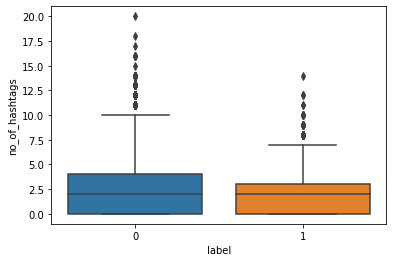

In [22]:
sns.boxplot(y= 'no_of_hashtags', x = 'label',data = data,orient = 'v' )
# Not sure if no of hashtag is important 

### 2.2 Univariate Analysis : 'tweet_len'

<AxesSubplot:xlabel='label', ylabel='tweet_len'>

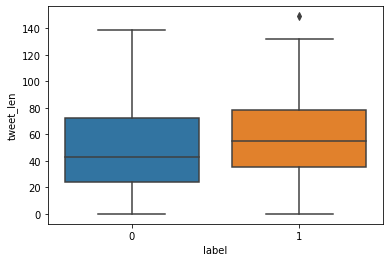

In [23]:
sns.boxplot(y= 'tweet_len', x = 'label',data = data,orient = 'v')
# Length seams like a useful attribute

### 2.3  Wordcloud for Neutral & Positive Sentiment Tweets

In [24]:
general_words = ' '.join([word for word in data['tweet'][data['label']==0]])
negetive_words = ' '.join([word for word in data['tweet'][data['label']==1]])

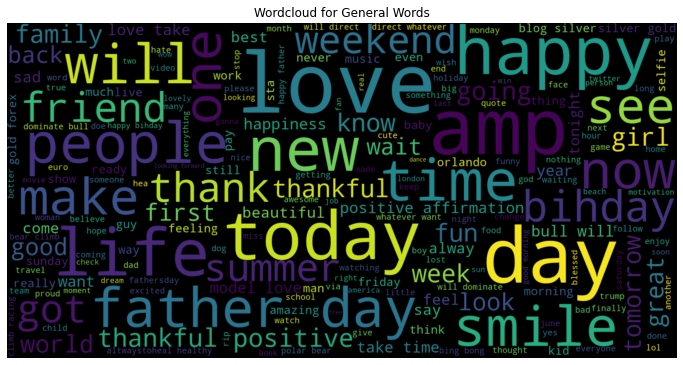

In [25]:
from wordcloud import WordCloud, STOPWORDS 
stopwords = set(STOPWORDS) 

wordcloud = WordCloud(width = 1600, height = 800,
            max_font_size = 200).generate(general_words)
plt.figure(figsize = (12,10))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.title('Wordcloud for General Words')
plt.axis('off')
plt.show()

- Tweets with positive sentiment have frequent words like happy,love,happy,birthday, thankful etc. which agrees with the sentiment

### 2.4 Wordcloud for Negetive Sentiment Tweets

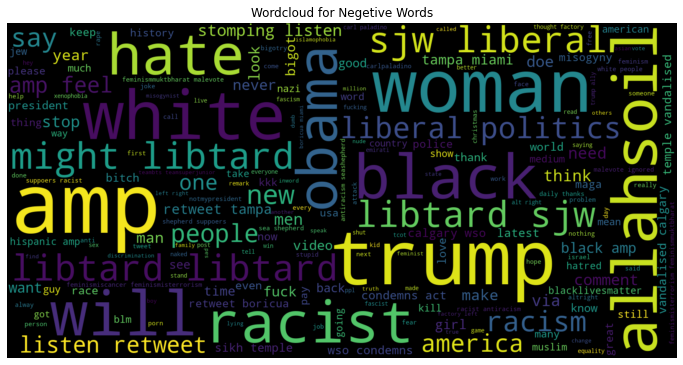

In [26]:
wordcloud = WordCloud(width = 1600, height = 800,
            max_font_size = 200).generate(negetive_words)
plt.figure(figsize = (12,10))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.title('Wordcloud for Negetive Words')
plt.axis('off')
plt.show()

- Tweets with Negetive sentiment contain freqent words like racist, black, liberal,libatard, white, hate, women etc which are compatiable with the sentiment i.e racist/sexist tweets

### 2.5 Frequent Hashtags for Neutral and Positive Tweets

In [27]:
#  Source- https://courses.analyticsvidhya.com/courses/take/twitter-sentiment-analysis/texts/6122248-story-generation-and-visualization-from-tweets
# Unnesting the lists as nltk freqdist won't accept list
General_hashtags = sum(General_hashtags,[ ])
Negetive_hashtags = sum(Negetive_hashtags,[ ])

General_hashtags = sum(General_hashtags,[ ])
Negetive_hashtags = sum(Negetive_hashtags,[ ])

In [28]:
# making a dict of general hastags and their counts
freq = nltk.probability.FreqDist(General_hashtags) 
top_hashtags = [k for k, v in sorted(freq.items(), key=lambda item: item[1], reverse = True)]
counts = [v for k, v in sorted(freq.items(), key=lambda item: item[1], reverse= True)]

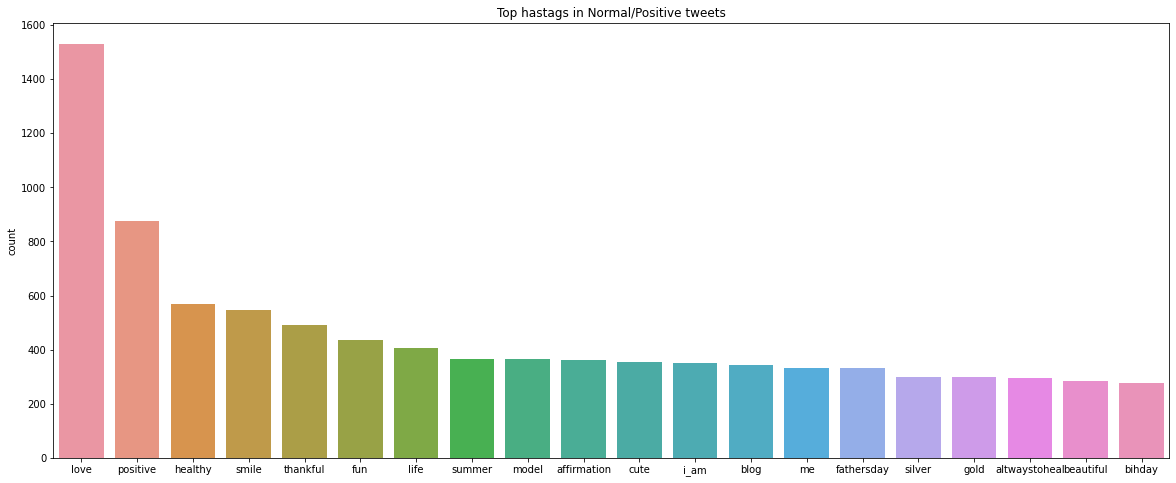

In [29]:
plt.figure(figsize= (20,8))
ax = sns.barplot(x = top_hashtags[:20], y = counts[:20])
ax.set(ylabel = 'count')
plt.title('Top hastags in Normal/Positive tweets')
plt.show()

- Mood in frequent hashtags completly agrees with the tweet sentiment

### 2.5 Frequent Hashtags for Negative Tweets

In [30]:
# making a dict of general hastags and their counts
freq2 = nltk.probability.FreqDist(Negetive_hashtags) 
top_hashtags = [k for k, v in sorted(freq2.items(), key=lambda item: item[1], reverse = True)]
counts = [v for k, v in sorted(freq2.items(), key=lambda item: item[1], reverse= True)]

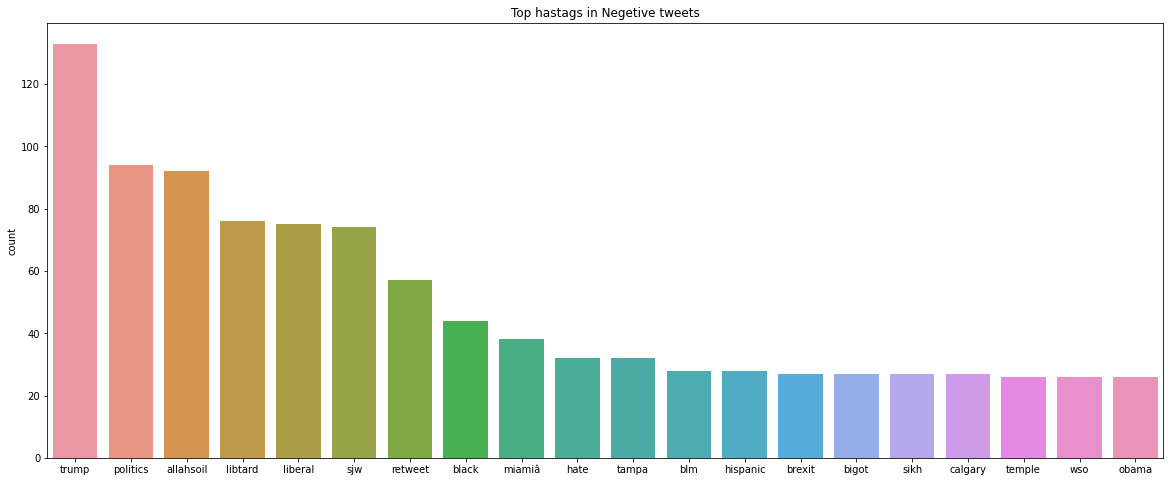

In [31]:
plt.figure(figsize= (20,8))
ax = sns.barplot(x = top_hashtags[:20], y = counts[:20])
ax.set(ylabel = 'count')
plt.title('Top hastags in Negetive tweets')
plt.show()

- Here in racist/sexit tweet also the mood of frequent hashtags mostly agrees with the tweet sentiment

## 3. Handling the imbalances in the dataset : Upsampling

In [32]:
Y = data['label'].values
X = data.drop(['label'], axis=1)

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, stratify=Y)
# Not splitting data for cv as Gridsearch CV takes care of it
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((21460, 3), (10570, 3), (21460,), (10570,))

In [34]:
# Joining labels to the train set in order to Upsample
X_train['label'] = y_train

In [35]:
count_class_0, count_class_1 = X_train.label.value_counts()

# Divide by class
df_class_0 = X_train[X_train['label'] == 0]
df_class_1 = X_train[X_train['label'] == 1]

In [36]:
from sklearn.utils import resample
df_class1_up = resample(df_class_1, replace = True, 
                        n_samples = df_class_0.shape[0],
                        random_state = 100)
df_class1_up.shape

(19915, 4)

In [37]:
train_up = pd.concat([df_class_0, df_class1_up])
train_up.shape

(39830, 4)

In [38]:
y_train_up = train_up['label']
X_train_up = train_up.drop(['label'],axis = 1)

In [39]:
from tqdm import tqdm
preprocessed_tweets = []
for sentance in tqdm(X_train_up['tweet'].values):
    sentance = ' '.join(e.lower() for e in sentance.split())
    preprocessed_tweets.append(sentance.strip())

100%|██████████| 39830/39830 [00:00<00:00, 586992.11it/s]


In [40]:

preprocessed_tweets_te = []
for sentance in tqdm(X_test['tweet'].values):
    sentance = ' '.join(e.lower() for e in sentance.split())
    preprocessed_tweets_te.append(sentance.strip())

100%|██████████| 10570/10570 [00:00<00:00, 596774.67it/s]


In [41]:
train_vocab = set()
for sentance in preprocessed_tweets:
    train_vocab.update(sentance.split())

test_vocab = set()
for sentance in preprocessed_tweets_te:
    test_vocab.update(sentance.split()) 
    
print('train vocab:{},test vocab:{}'.format(len(train_vocab),len(test_vocab)))
print('common word in test:', len(train_vocab.intersection(test_vocab))/len(y_test))


train vocab:27081,test vocab:17218
common word in test: 0.8905392620624408


- 88% of the test Vocabulary is present in train which implies test dataset is not very differnt from train set

## 4. Feature Encoding 

##  4.1 Encoding Text Feature

### 4.1.1 TfIdf Encoding for tweets

In [42]:
tfidf = TfidfVectorizer(min_df = 3)

X_train_tfidf = tfidf.fit_transform(X_train_up['tweet'].values)
X_test_tfidf = tfidf.transform(X_test['tweet'].values)
print(X_train_tfidf.shape, y_train_up.shape)
print(X_test_tfidf.shape, y_test.shape)

(39830, 8080) (39830,)
(10570, 8080) (10570,)


In [43]:
import pickle 
pickle.dump(tfidf, open('tfidf.pkl', 'wb'))

In [44]:
with open('tfidf.pkl', 'rb') as file:  
    tfidf2 = pickle.load(file)

### 4.1.2  BOW

In [45]:
vectorizer = CountVectorizer(min_df = 3)
bow = vectorizer.fit(X_train_up['tweet'].values)
X_train_bow = bow.transform(X_train_up['tweet'].values)
X_test_bow = bow.transform(X_test['tweet'].values)
print(X_train_bow.shape, y_train_up.shape)
print(X_test_bow.shape, y_test.shape)

(39830, 8080) (39830,)
(10570, 8080) (10570,)


In [46]:
pickle.dump(bow, open("bow.pkl", "wb"))

### 4.1.3 Training Word2vec based on train data

In [47]:
tokenized_tweets = X_train_up['tweet'].apply(lambda x: x.split())
import gensim
model_w2v = gensim.models.Word2Vec(tokenized_tweets, size = 200,
                                  window = 5, min_count = 2,
                                  sg = 1, hs = 0,
                                  negative = 10, workers = 2, seed = 34)

In [48]:
model_w2v.wv.most_similar(positive = 'spring')

[('warm', 0.9803078174591064),
 ('moon', 0.97575843334198),
 ('sunrise', 0.9708738327026367),
 ('sundayfunday', 0.9656395316123962),
 ('flip', 0.9655642509460449),
 ('sunset', 0.9644584059715271),
 ('cloud', 0.9627646207809448),
 ('goodvibes', 0.9583637118339539),
 ('bliss', 0.9560425877571106),
 ('goodday', 0.9555832743644714)]

In [49]:
model_w2v.wv.most_similar(positive = 'trump')

[('butt', 0.6277019381523132),
 ('prediction', 0.6251607537269592),
 ('astrology', 0.6170469522476196),
 ('vedic', 0.6166263222694397),
 ('buddy', 0.6137441992759705),
 ('commie', 0.6099554300308228),
 ('disenfranchised', 0.6096207499504089),
 ('lawmaker', 0.5987545251846313),
 ('putin', 0.5925769209861755),
 ('rockineve', 0.5857788324356079)]

- Model Seems to be trained well on train data

In [50]:
# Training Data
avg_w2v_vectors = []
for sentence in tqdm(X_train_up['tweet']):
    vector = np.zeros(200)
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split():
        if word in model_w2v.wv.vocab.keys():
            vector += model_w2v[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors.append(vector)

100%|██████████| 39830/39830 [00:02<00:00, 19739.44it/s]


In [51]:
# Test Data
avg_w2v_te = []
for sentence in tqdm(X_test['tweet']):
    vector_te = np.zeros(200)
    for word in sentence.split():
        if (word in model_w2v.wv.vocab.keys()) and (word in train_vocab):
            vector_te += model_w2v[word]
            cnt_words += 1
    if cnt_words != 0:
        vector_te /= cnt_words
    avg_w2v_te.append(vector_te)
    
print(len(avg_w2v_te))
print(len(avg_w2v_te[0]))

100%|██████████| 10570/10570 [00:00<00:00, 20343.96it/s]

10570
200


In [52]:
avg_w2v_vectors = np.array(avg_w2v_vectors)
avg_w2v_te = np.array(avg_w2v_te)

###  4.1.4 Average word2vec for each tweet from a Glove  Model Pretrained on tweet data.


In [53]:
import pickle
with open('glove.twitter.27B.200d.pkl','rb') as f:
    w2v_model_g = pickle.load(f)
    glove_words = set(w2v_model_g.keys())

In [54]:
# Training Data
avg_w2v_vectors_glove = []
for sentence in tqdm(X_train_up['tweet']):
    vector = np.zeros(200)
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split():
        if word in glove_words:
            vector += w2v_model_g[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors_glove.append(vector)
    
print(len(avg_w2v_vectors))
print(len(avg_w2v_vectors[0]))

100%|██████████| 39830/39830 [00:00<00:00, 59584.83it/s]

39830
200


In [55]:
# Test Data
avg_w2v_te_glove = []
for sentence in tqdm(X_test['tweet']):
    vector_te = np.zeros(200)
    for word in sentence.split():
        if (word in glove_words) and (word in train_vocab):
            vector_te += w2v_model_g[word]
            cnt_words += 1
    if cnt_words != 0:
        vector_te /= cnt_words
    avg_w2v_te_glove.append(vector_te)
    
print(len(avg_w2v_te))
print(len(avg_w2v_te[0]))

100%|██████████| 10570/10570 [00:00<00:00, 57730.73it/s]

10570
200


In [56]:
avg_w2v_vectors_glove = np.array(avg_w2v_vectors_glove)
avg_w2v_te_glove = np.array(avg_w2v_te_glove)

### 4.1.5 Tfidf Weighted Word2vec

In [57]:
tfidf_model = TfidfVectorizer()
tfidf_model.fit(X_train_up['tweet'].values)
# Getting idf values for train vocab
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

In [58]:
tfidf_w2v_vectors = []
for sentence in tqdm(X_train_up['tweet'].values): 
    vector = np.zeros(200) 
    tf_idf_weight =0
    for word in sentence.split(): 
        if (word in glove_words) and (word in tfidf_words):
            vec = w2v_model_g[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors.append(vector)

print(len(tfidf_w2v_vectors),len(tfidf_w2v_vectors[0]))

100%|██████████| 39830/39830 [00:01<00:00, 20639.72it/s]

39830 200


In [59]:
# Test Set
tfidf_w2v_vectors_te = []
for sentence in tqdm(X_test['tweet'].values): # Using the same IDF values obtained from train set
    vector = np.zeros(200) 
    tf_idf_weight =0
    for word in sentence.split(): 
        if (word in glove_words) and (word in tfidf_words):
            vec = w2v_model_g[word] 
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) 
            vector += (vec * tf_idf) 
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors_te.append(vector)

100%|██████████| 10570/10570 [00:00<00:00, 20983.92it/s]


In [60]:
tfidf_w2v_vectors = np.array(tfidf_w2v_vectors)
tfidf_w2v_vectors_te = np.array(tfidf_w2v_vectors_te)
tfidf_w2v_vectors.shape,tfidf_w2v_vectors_te.shape

((39830, 200), (10570, 200))

## 4.2 Feature Engineering :Sentiment score

In [61]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/meg/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [62]:
y_train_up

26858    0
5898     0
4200     0
25486    0
14633    0
        ..
526      1
16855    1
20294    1
23505    1
9873     1
Name: label, Length: 39830, dtype: int64

In [63]:
test_tweet = X_train_up['tweet'].iloc[100]
print(test_tweet, y_train_up.iloc[100])

feel much better new vapegirl lifeisgood keepsmiling selfie goodfeeling 0


In [64]:
sd = sid.polarity_scores(test_tweet)
for k in sd:
    print('{0}: {1}, '.format(k, sd[k]), end='')

neg: 0.0, neu: 0.734, pos: 0.266, compound: 0.4404, 

In [65]:
# Training set
v = []
for i in X_train_up['tweet']:
    snt = sid.polarity_scores(i)
    v.append(snt)

In [66]:
data_fr = pd.DataFrame(v)
X_train_senti = np.array(data_fr)
X_train_senti.shape

(39830, 4)

In [67]:
v2 = []
for i in X_test['tweet'] :
    snte = sid.polarity_scores(i)
    v2.append(snte)
    
data_fr_te = pd.DataFrame(v2)
X_test_senti = np.array(data_fr_te)
X_test_senti.shape

(10570, 4)

## 4.3 Normalizing the numerical features

In [68]:
from sklearn.preprocessing import normalize

In [69]:
X_train_hashtags, norm_hs = normalize(X_train_up['no_of_hashtags'].values.reshape(1,-1), return_norm= True)
X_test_hashtags = (X_test['no_of_hashtags'].values.reshape(1,-1) / norm_hs)

X_train_hashtags = X_train_hashtags.T
X_test_hashtags = X_test_hashtags.T
print("After vectorizations")
print(X_train_hashtags.T.shape)
print(X_test_hashtags.T.shape)

After vectorizations
(1, 39830)
(1, 10570)


In [70]:
X_train_tweet_len, norm_len = normalize(X_train_up['tweet_len'].values.reshape(1,-1), return_norm = True)
X_test_tweet_len = (X_test['tweet_len'].values.reshape(1,-1)/ norm_len)

X_train_tweet_len = X_train_tweet_len.T
X_test_tweet_len = X_test_tweet_len.T
X_test_hashtags
print("After vectorizations")
print(X_train_tweet_len.shape)
print(X_test_tweet_len.shape)

After vectorizations
(39830, 1)
(10570, 1)


In [71]:
with open('norms.pkl', 'wb') as f:
    pickle.dump([norm_hs, norm_len], f)

In [72]:
with open('norms.pkl', 'rb') as f:  
    obj0, obj1 = pickle.load(f)
print(obj0, obj1)

[638.35726674] [12302.57001606]


<h2> 5. Combining Feature and preparing trainingsets </h2>

### 5.1 Set-1 with tfidf encoding of tweet

In [73]:
from scipy.sparse import hstack
X_tr1 = hstack((X_train_tfidf,
                X_train_hashtags,
                X_train_tweet_len,
               X_train_senti)).tocsr()
X_te1 = hstack((X_test_tfidf,
                X_test_hashtags,
                X_test_tweet_len,
               X_test_senti)).tocsr()

In [74]:
print("Set1 Data matrix")
print(X_tr1.shape, y_train.shape)
print(X_te1.shape, y_test.shape)

Set1 Data matrix
(39830, 8086) (21460,)
(10570, 8086) (10570,)


### 5.2 Set-2 with Bow encoding of tweet

In [75]:
X_tr2 = hstack((X_train_bow,
                X_train_hashtags,
                X_train_tweet_len,
               X_train_senti)).tocsr()
X_te2 = hstack((X_test_bow,
                X_test_hashtags,
                X_test_tweet_len,
               X_test_senti)).tocsr()

In [76]:
print("Set2 Data matrix")
print(X_tr2.shape, y_train.shape)
print(X_te2.shape, y_test.shape)

Set2 Data matrix
(39830, 8086) (21460,)
(10570, 8086) (10570,)


### 5.3 Set-3 with w2v encoding of tweet

In [77]:
X_tr3 = np.hstack((avg_w2v_vectors,
                X_train_hashtags,
                X_train_tweet_len,
               X_train_senti))
X_te3 = np.hstack((avg_w2v_te,
                X_test_hashtags,
                X_test_tweet_len,
               X_test_senti))

In [78]:
print("Set-3 Data matrix")
print(X_tr3.shape, y_train.shape)
print(X_te3.shape, y_test.shape)

Set-3 Data matrix
(39830, 206) (21460,)
(10570, 206) (10570,)


### 5.4 Set-4 with Glove pretrained w2v encoding of tweet

In [79]:
X_tr4 = np.hstack((avg_w2v_vectors_glove,
                X_train_hashtags,
                X_train_tweet_len,
               X_train_senti))
X_te4 = np.hstack((avg_w2v_te_glove,
                X_test_hashtags,
                X_test_tweet_len,
               X_test_senti))

In [80]:
print("Set-4 Data matrix")
print(X_tr4.shape, y_train.shape)
print(X_te4.shape, y_test.shape)

Set-4 Data matrix
(39830, 206) (21460,)
(10570, 206) (10570,)


### 5.5 Set-5 with tfidf weighted w2v encoding of tweet

In [81]:
X_tr5 = np.hstack((tfidf_w2v_vectors,
                X_train_hashtags,
                X_train_tweet_len,
               X_train_senti))
X_te5 = np.hstack((tfidf_w2v_vectors_te,
                X_test_hashtags,
                X_test_tweet_len,
               X_test_senti))

In [82]:
print("Set-5 Data matrix")
print(X_tr5.shape, y_train.shape)
print(X_te5.shape, y_test.shape)

Set-5 Data matrix
(39830, 206) (21460,)
(10570, 206) (10570,)


## 6. Training the Models

### 6.1 Training a Baseline Model on Set-1

In [83]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score

In [84]:
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
clf.fit(X_tr1.toarray(), y_train_up)

GaussianNB()

In [85]:
f1_score(y_train_up, clf.predict(X_tr1.toarray())),f1_score(y_test,clf.predict(X_te1.toarray()))

(0.9176996451776416, 0.331560838285893)

### 6.2 Training on all the sets on RandomForest

#### 6.2.1 Set-1

In [86]:
clf_rf1 = RandomForestClassifier( n_estimators= 250,random_state = 12)
clf_rf1.fit(X_tr1,y_train_up)

RandomForestClassifier(n_estimators=250, random_state=12)

In [87]:
from sklearn.metrics import f1_score
f1_score(y_train_up, clf_rf1.predict(X_tr1)),f1_score(y_test,clf_rf1.predict(X_te1))

(0.9998995832705729, 0.6152584085315832)

#### 6.2.1 Set-2

In [88]:
clf_rf2 = RandomForestClassifier(n_estimators=250, random_state=12)
clf_rf2.fit(X_tr2, y_train_up)
f1_score(y_train_up, clf_rf2.predict(X_tr2)),f1_score(y_test,clf_rf2.predict(X_te2))

(0.9998995832705729, 0.6291946308724833)

#### 6.2.1 Set-3

In [89]:
clf_rf3 = RandomForestClassifier(n_estimators=250, random_state=12)
clf_rf3.fit(X_tr3, y_train_up)
f1_score(y_train_up, clf_rf3.predict(X_tr3)),f1_score(y_test,clf_rf3.predict(X_te3))

(0.9998995832705729, 0.002607561929595828)

#### 6.2.1 Set-4

In [90]:
clf_rf4 = RandomForestClassifier(n_estimators=250, random_state=12)
clf_rf4.fit(X_tr4, y_train_up)
f1_score(y_train_up, clf_rf4.predict(X_tr4)),f1_score(y_test,clf_rf4.predict(X_te4))

(0.9998995832705729, 0.005208333333333333)

#### 6.2.1 Set-5

In [91]:
clf_rf5 = RandomForestClassifier(n_estimators=250, random_state=12)
clf_rf5.fit(X_tr5, y_train_up)
f1_score(y_train_up, clf_rf4.predict(X_tr5)),f1_score(y_test,clf_rf5.predict(X_te5))

(0.8106026685770574, 0.4933837429111531)

- Tfidf encoded  and BOW encoded train sets seems to perform better than the rest of the sets.
- Though word2vec models are powerful, they are performing very poorly on the test set. This is might because of small size of our train set.
- Tfidf weighted W2v is performing better than normal word2vec but not better than tfidf model.


### Finetuning Bow and Tfidf based Models

In [92]:
bst = RandomForestClassifier( bootstrap= False, n_estimators= 500,min_samples_leaf= 2,
                             min_samples_split= 5,
                             random_state = 10)
bst.fit(X_tr1,y_train_up)

RandomForestClassifier(bootstrap=False, min_samples_leaf=2, min_samples_split=5,
                       n_estimators=500, random_state=10)

In [93]:
f1_score(y_train_up, bst.predict(X_tr1)),f1_score(y_test,bst.predict(X_te1))

(0.9937018894331702, 0.6262626262626263)

In [131]:
# Trying Logestic Regression
from sklearn.linear_model import LogisticRegression
lr2 = LogisticRegression( C = 2)
lr2.fit(X_tr2, y_train_up)
f1_score(y_train_up, lr2.predict(X_tr1)),f1_score(y_test,lr2.predict(X_te1))

(0.7897099866521053, 0.5277280858676208)

test auc: 0.7923168925960216
train auc: 0.9936731107205624


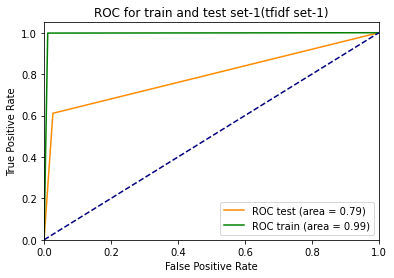

In [94]:
#https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
fpr_t, tpr_t, thresholds = roc_curve(y_train_up, bst.predict(X_tr1))
fpr, tpr, thresholds = roc_curve(y_test,bst.predict(X_te1))


auc_te1 = auc(fpr, tpr)
auc_tr1 = auc(fpr_t, tpr_t)
print('test auc:',auc_te1)
print('train auc:',auc_tr1)
plt.plot(fpr, tpr, color='darkorange'
         , label='ROC test (area = %0.2f)' % auc_te1)
plt.plot(fpr_t, tpr_t, color='green'
         , label='ROC train (area = %0.2f)' % auc_tr1)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for train and test set-1(tfidf set-1)')
plt.legend(loc="lower right")
plt.show()

Text(0.5, 1.0, 'confusion matrix for test set encoded by tfidf ')

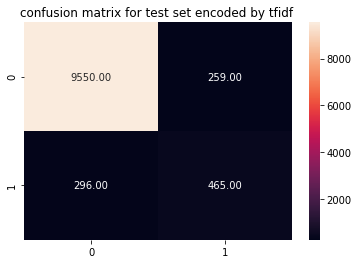

In [95]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
c = confusion_matrix(y_test, bst.predict(X_te1))
sns.heatmap(c, annot= True, fmt = '.2f')
plt.title('confusion matrix for test set encoded by tfidf ')

#### BOW based model

In [129]:
# Trying Logestic regression
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression( C = 2)
lr.fit(X_tr2, y_train_up)
f1_score(y_train_up, lr.predict(X_tr2)),f1_score(y_test,lr.predict(X_te2))

LogisticRegression(C=2)

In [130]:
f1_score(y_train_up, lr.predict(X_tr2)),f1_score(y_test,lr.predict(X_te2))

(0.9936523069975162, 0.65892972275951)

In [114]:
# Random Forest
bst2 = RandomForestClassifier( bootstrap= False, n_estimators= 1000,min_samples_leaf= 2,
                             min_samples_split= 2,
                             random_state = 10)
bst2.fit(X_tr2,y_train_up)

RandomForestClassifier(bootstrap=False, min_samples_leaf=2, n_estimators=1000,
                       random_state=10)

In [97]:
f1_score(y_train_up, bst2.predict(X_tr2)),f1_score(y_test,bst2.predict(X_te2))

(0.9886372149938816, 0.627062706270627)

##### Plotting performance of Logestic Regression on set2

test auc: 0.8215208109584256
train auc: 0.9936480040170725


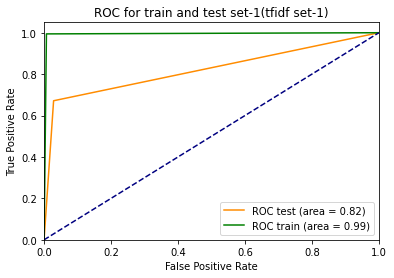

In [132]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
fpr_t, tpr_t, thresholds = roc_curve(y_train_up, lr.predict(X_tr2))
fpr, tpr, thresholds = roc_curve(y_test,lr.predict(X_te2))


auc_te1 = auc(fpr, tpr)
auc_tr1 = auc(fpr_t, tpr_t)
print('test auc:',auc_te1)
print('train auc:',auc_tr1)
plt.plot(fpr, tpr, color='darkorange'
         , label='ROC test (area = %0.2f)' % auc_te1)
plt.plot(fpr_t, tpr_t, color='green'
         , label='ROC train (area = %0.2f)' % auc_tr1)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for train and test set-1(tfidf set-1)')
plt.legend(loc="lower right")
plt.show()

Text(0.5, 1.0, 'confusion matrix for test set encoded by Binary BOW ')

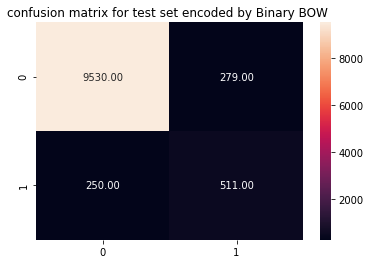

In [134]:
c2 = confusion_matrix(y_test, lr.predict(X_te2))
sns.heatmap(c2, annot= True, fmt = '.2f')
plt.title('confusion matrix for test set encoded by Binary BOW ')

- Model with BOW encoded input is performing better among the both so aving it for future use

In [135]:
import pickle 
pickle.dump(bst2, open('lr_model.pkl', 'wb'))

In [136]:
from sklearn.metrics import classification_report
print('For Train Set:')
print(classification_report(y_train_up, bst2.predict(X_tr2), labels=[0,1]))
print('='*60)
print('For Test Set:')
print(classification_report( y_test, bst2.predict(X_te2), labels=[0,1]))

For Train Set:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99     19915
           1       0.98      0.99      0.99     19915

    accuracy                           0.99     39830
   macro avg       0.99      0.99      0.99     39830
weighted avg       0.99      0.99      0.99     39830

For Test Set:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      9809
           1       0.63      0.62      0.63       761

    accuracy                           0.95     10570
   macro avg       0.80      0.80      0.80     10570
weighted avg       0.95      0.95      0.95     10570



<h2> Summary </h2>

In [102]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Vectorizer", "Train F1-Score", "Test F1-Score"]
x.add_row(["TfIdf", 0.9998, 0.60441])
x.add_row(["BOW",0.9990, 0.6208])
x.add_row(["Custom word2vec", 0.9991, 0.0])
x.add_row(["Glove Twitter Word2vec", 0.9992, 0.0])
x.add_row(["Tfidf Weighted W2v", 0.7896, 0.4748])
print(x)

+------------------------+----------------+---------------+
|       Vectorizer       | Train F1-Score | Test F1-Score |
+------------------------+----------------+---------------+
|         TfIdf          |     0.9998     |    0.60441    |
|          BOW           |     0.999      |     0.6208    |
|    Custom word2vec     |     0.9991     |      0.0      |
| Glove Twitter Word2vec |     0.9992     |      0.0      |
|   Tfidf Weighted W2v   |     0.7896     |     0.4748    |
+------------------------+----------------+---------------+


> From above observations, we can say that for smaller training sets its better to use simple vectorizers like tfidf and bow instead of Powerful vectorizer method like word2vec as they tend to overfit and perform poorly on the test set

In [139]:
np.array([0])[0]

0